# Calculating the absorption and scattering cross section using a probability distribution

In [1]:
import time
# AA = time.time()
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spit
import os
print('hello world')


hello world








### First, we specify which dust we are using

In [2]:
dust_dir = ['/home/physics/Research/DUSTY/DUSTY/Lib_nk/', 
            "C:/UTSA/Research/DUSTY/DUSTY/Lib_nk/"]
# this is the possible locations of where dust can be


nk_path = dust_dir[0]               #where the dust is 
dust = 'oliv_nk_y.nk'                  #DUST NAME HERE #grf
rho = 3.33 #grams cm**-3            #density
pathy = os.path.join(nk_path, dust) #pipeline is open
wavelen, n_dust, k_dust = np.loadtxt(pathy, skiprows=12, unpack=True)
                                    #lamda, n, and k values are extracted
m = np.array([complex(n_dust[i], k_dust[i]) for i in range(len(wavelen))])
                                    #joins n, k values into complex number
    
wavelen = wavelen**(-1) * 10000   #Convert wavelen2 to waveLENGTH from waveNUMBER
print('hello world')


hello world


### This defines the probability distribution

In [3]:
def probability(dis_name, l1, l2, lmin=0.05, m1=0, m2=0, d=0):
    '''
    This is the probability distribution as a function of L1 and L2, the 
    geometric parameters. This parameter gets inserted into the integral that 
    calculates the average polarizability per unit volume

    Parameters
    ----------
    dis_name : String
        This specifies the distribution we will be using. 
        'CDE' = Continuous Distribution of Ellipsoids
        'ERCDE' = Externally Restricted CDE, returns CDE if lmin=0
        'tCDE' = truncated CDE, REQUIRES MORE WORK
    l1 : Float
        Largest Geometric Constant, lmin<l1<1.0
    l2 : Float
        Second Largest Geometric Constant, lmin<l2<=l1
    lmin : Float, optional
        Minimum allowed geometric constant.  The default is 0.

    Returns
    -------
    Float
        Function dependent on l1 and l2

    '''
    l3 = 1 - l1 - l2
    if dis_name == 'CDE':
        return 2
    elif dis_name == 'CDE2':
        return 120 * l1 * l2 * l3
    elif dis_name == 'ERCDE':
        return 2/((1 - (3*lmin))**2)
    elif dis_name == 'tCDE':
        return 1/((1-d-m2)*(1-m1-m2-d) - 0.5*((1-d-m2)**2) - m1**2)
        
    
print('hello world')

hello world


### Now we define our volume function. v_avg is used to calculate sigma below

In [4]:
def volume_integrand_mrn(r, q):
    v = r**(-q)
    return v


rmin = 0.005
rmax = 0.25
q = 3.5

r_integral = spit.quad(volume_integrand_mrn, rmin, rmax, args=q)
r_average = ((1/(rmax - rmin)) * r_integral[0])**(1/-q)
v_avg = (4./3.) * np.pi * r_average**3



### creates function that calculates Sigma, defined in eq 13 in Min et al 2003

In [5]:
def sigma(m, lamda, v):
    sig = []
    for i in range(len(lamda)):
        k = (2.0 * np.pi)/lamda[i]
        term1 = (6.0*np.pi) / (v * (k**3))
        term2 = np.imag((m[i]**2))
        term3 = 1.0 / abs(m[i]**2 - 1)**2
        sig.append(term1 * term2 * term3)
    return sig
print('hello world')

hello world


### creates our bounds for our geometric factors. The bounds are the sides of a triangle in (l1, l2) space

In [6]:
def bounds_l1():
    return [0,1]

def bounds_l2(l1):
    return [0,1-l1]
print('hello world')


hello world


### This is where we calculate the absorption cross-section (Cabs). It creates an empty list, then calculates Cabs for a CDE distribution at each wavelength as described in Min 03, eqn 15. It then uses this to find the shape averaged mass absorption coefficient for particles of a given volume, as described in Min 03, eqn 39

In [7]:
aa = time.time()
cabs_cde = []
for j in range(len(m)):
    def f(l1, l2, n=m[j], dis_name='CDE'):
        b = 1/(n**2 - 1)
        term1 = 1/3 * 1/(b + l1)
        term2 = 1/3 * 1/(b + l2)
        term3 = 1/3 * 1/(b + 1 - l1 - l2)
        # r = np.real((term1 + term2 + term3)*probability(dis_name, l1, l2))
        j = np.imag((term1 + term2 + term3)*probability(dis_name, l1, l2))
        return j
        # return np.real((term1 + term2 + term3)*probability(dis_name, l1, l2)) + np.imag((term1 + term2 + term3)*probability(dis_name, l1, l2))
    cabs_cde.append(spit.nquad(f, [bounds_l2, bounds_l1])[0])
kappa_cde = np.array((cabs_cde))
kappa_cde *= (2 * np.pi / (1e-4*wavelen)) * v_avg

bb = time.time()
print('This took {} seconds to run'.format(bb-aa))

This took 19.07443904876709 seconds to run


### Same as above, using CDE2 distribution

In [8]:
aa = time.time()
cabs_cde2 = []
for j in range(len(m)):
    def f(l1, l2, n=m[j], dis_name='CDE2'):
        b = 1/(n**2 - 1)
        term1 = 1/3 * 1/(b + l1)
        term2 = 1/3 * 1/(b + l2)
        term3 = 1/3 * 1/(b + 1 - l1 - l2)
        # r = np.real((term1 + term2 + term3)*probability(dis_name, l1, l2))
        j = np.imag((term1 + term2 + term3)*probability(dis_name, l1, l2))
        return j
        # return np.real((term1 + term2 + term3)*probability(dis_name, l1, l2)) + np.imag((term1 + term2 + term3)*probability(dis_name, l1, l2))
    cabs_cde2.append(spit.nquad(f, [bounds_l2, bounds_l1])[0])

kappa_cde2 = np.array((cabs_cde2))
kappa_cde2 *= (2 * np.pi / (1e-4*wavelen)) * v_avg
bb = time.time()
print('This took {} seconds to run'.format(bb-aa))

This took 18.576597690582275 seconds to run


### Same as above, using ERCDE distribution

In [9]:
aa = time.time()
cabs_ercde = []
for j in range(len(m)):
    def f(l1, l2, n=m[j], dis_name='ERCDE'):
        b = 1/(n**2 - 1)
        term1 = 1/3 * 1/(b + l1)
        term2 = 1/3 * 1/(b + l2)
        term3 = 1/3 * 1/(b + 1 - l1 - l2)
        # r = np.real((term1 + term2 + term3)*probability(dis_name, l1, l2))
        j = np.imag((term1 + term2 + term3)*probability(dis_name, l1, l2))
        return j
        # return np.real((term1 + term2 + term3)*probability(dis_name, l1, l2)) + np.imag((term1 + term2 + term3)*probability(dis_name, l1, l2))
    cabs_ercde.append(spit.nquad(f, [bounds_l2, bounds_l1])[0])

kappa_ercde = np.array((cabs_ercde))
kappa_ercde *= (2 * np.pi / (1e-4*wavelen)) * v_avg
bb = time.time()
print('This took {} seconds to run'.format(bb-aa))

This took 21.600193738937378 seconds to run


### Spheres only

In [20]:
cabs_spheres = []
for j in range(len(m)):
    cabs_spheres.append((2 * np.pi / (1e-4*wavelen[j]))*v_avg*np.imag(3*(m[j]**2 - 1)/(m[j]**2 + 2)))
cabs_sph_array = np.array((cabs_spheres))

### Here is where everything culminates. It gives us our required data in a table that can be input into DUSTY

In [11]:
Cabs_array = np.array((cabs_cde))
sig = np.array((sigma(m, wavelen, v_avg)))
Csca_array = Cabs_array/sig

output = np.transpose((wavelen, Cabs_array, Csca_array))


## This is where the text file is created with it's appropriate header

In [12]:
# line0 = f'standard mrn mixture (a_min = {rmin}, amax = {rmax})\n'
# # line1 = f'dust, weight: {dust[:-3]}, {wt_a}; {dust2[:-3]}, {wt_b}; {dust3[:-3]}, {wt_c}\n'
# line2 = ' lambda \t <C_abs>/v \t <C_sca>/v\n'

# f = open('look at this.dat', 'w')
# f.write(line0)
# # f.write(line1)
# f.write(line2)
# # f.write(str(output))


# for i in range(len(output)):
#     f.write(f"{output[i,0]} \t {output[i,1]} \t {output[i,2]}\n")


# f.close()


In [13]:
print('hello world')

hello world


In [19]:
plt.close('all')

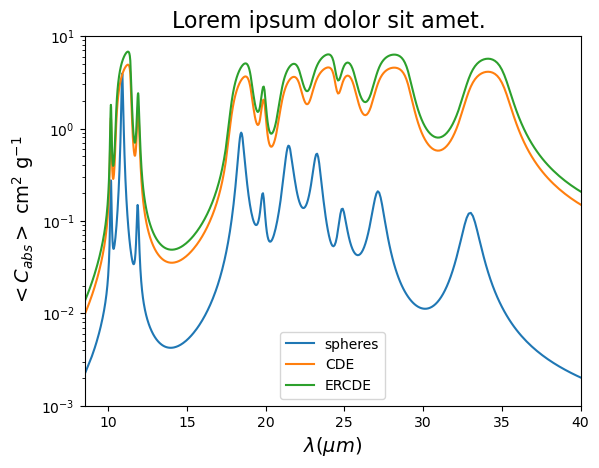

In [24]:
fig, ax = plt.subplots()
title = 'Lorem ipsum dolor sit amet. '
ax.set(xscale='linear', yscale='log', xlim=(8.5,40), ylim=(0.001, 10))
ax.set_title(title, fontsize=16)
ax.set_xlabel(r'$\lambda (\mu m)$', fontsize=14)
ax.set_ylabel(r'$<C_{abs}>$ cm$^{2}$ g$^{-1}$', fontsize=14)
ax.plot(wavelen, cabs_sph_array, label='spheres')
ax.plot(wavelen, np.array((cabs_cde)), label='CDE')
ax.plot(wavelen, np.array((cabs_ercde)), label='ERCDE')
ax.legend()